In [7]:
import torch
import triton

device = torch.device("cuda")

from numba_mm import launch_smem_numba_matmul

In [8]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_smem_numba_matmul(out, a, b, M, N, K)
    return out

In [9]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), size

In [10]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['numba', 'torch'],
                             line_names=[
                                 "Numba",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="smem-numba-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'numba':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

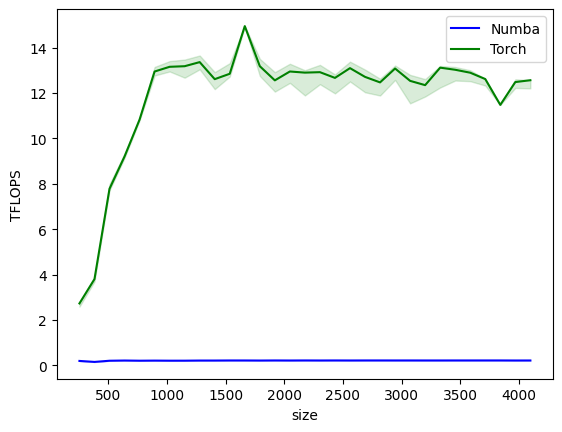

smem-numba-matmul-perf:
      size     Numba      Torch
0    256.0  0.196805   2.730667
1    384.0  0.153580   3.801229
2    512.0  0.205548   7.781640
3    640.0  0.214902   9.204494
4    768.0  0.206833  10.830739
5    896.0  0.211458  12.948646
6   1024.0  0.207621  13.156021
7   1152.0  0.208226  13.182243
8   1280.0  0.213811  13.362422
9   1408.0  0.214095  12.611641
10  1536.0  0.217438  12.848811
11  1664.0  0.217014  14.948359
12  1792.0  0.214239  13.182142
13  1920.0  0.218046  12.558709
14  2048.0  0.215536  12.949130
15  2176.0  0.218364  12.899774
16  2304.0  0.216234  12.919347
17  2432.0  0.218247  12.667646
18  2560.0  0.216396  13.097213
19  2688.0  0.217956  12.712083
20  2816.0  0.218202  12.469218
21  2944.0  0.217538  13.080324
22  3072.0  0.217747  12.536683
23  3200.0  0.217099  12.348061
24  3328.0  0.217196  13.117948
25  3456.0  0.217894  13.025505
26  3584.0  0.217836  12.896065
27  3712.0  0.218333  12.616237
28  3840.0  0.218232  11.478003
29  3968.0  0.21

In [11]:
benchmark.run(show_plots=True, print_data=True)

In [12]:
torch.cuda.empty_cache()